In [1]:
import sys
from copy import deepcopy
from geoopt.optim import RiemannianAdam
sys.path.append("./")
sys.path.append("../")
sys.path.append("../../")
import numpy as np
import json
import pickle
import os
import torch
from rnn_coach.src.RNN_torch import *
from rnn_coach.src.DynamicSystemAnalyzer import *
from rnn_coach.src.RNN_numpy import *
from rnn_coach.src.Task import *
from rnn_coach.src.DataSaver import *
from src.utils import jsonify
from latent_circuit_inference.src.LatentCircuit import *
from latent_circuit_inference.src.LatentCircuitFitter import *
from latent_circuit_inference.src.LCAnalyzer import *
from latent_circuit_inference.src.utils import *
from latent_circuit_inference.src.circuit_vizualization import *
from matplotlib import pyplot as plt
from scipy.stats import zscore
import pickle
import json
from pathlib import Path
from tqdm.auto import tqdm
from rnn_coach.src.utils import get_colormaps
colors, cmp = get_colormaps()

In [2]:
def mse_scoring(x, y):
    return np.mean((x - y) ** 2)

def R2(x, y):
    return 1.0 - mse_scoring(x, y)/np.var(y)

def plot_matrix(mat, vmin=None, vmax=None, show_numbers = False, figsize = (7,7)):
    if vmin is None:
        vmin = np.min(mat)
    if vmax is None:
        vmax = np.max(mat)    
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    img = ax.imshow(mat, cmap=cmp, vmin = vmin, vmax = vmax)
    if show_numbers:
        for (i, j), z in np.ndenumerate(mat):
            if np.abs(z) > 0.01:
                ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
    ax.set_xticks(np.arange(mat.shape[1])[::2])
    ax.set_yticks(np.arange(mat.shape[0])[::2])
    plt.show()

    
def permute_input_matrix(mat, order):
    new_mat = np.empty_like(mat)
    for i, r in enumerate(order):
        new_mat[i, :] = mat[r, :]
    return new_mat

projects_folder = str(Path.home()) + "/Documents/GitHub/"
RNN = '0.0018708_CDDM_tanh;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.002;maxiter=3000'
RNN_folder = RNN
RNNs_path = os.path.join(projects_folder, "rnn_coach", "data", "trained_RNNs", "CDDM_tanh")
RNN_score = float(RNN.split("_")[0])
RNN_path = os.path.join(RNNs_path, RNN)
rnn_config = json.load(open(os.path.join(RNN_path, f"{RNN_score}_config.json"), "rb+"))
rnn_data = json.load(open(os.path.join(RNN_path, f"{RNN_score}_params_CDDM_tanh.json"), "rb+"))
train_config_file = f"train_config_CDDM_relu.json"

activation_name = rnn_config["activation"]
RNN_N = rnn_config["N"]
n_steps = rnn_config["n_steps"]
task_params = rnn_config["task_params"]
activation_torch = lambda x: torch.maximum(x, torch.tensor(0))
dt = rnn_config["dt"]
tau = rnn_config["tau"]
connectivity_density_rec = rnn_config["connectivity_density_rec"]
spectral_rad = rnn_config["sr"]
sigma_inp = 0.03
sigma_rec = 0.03
seed = np.random.randint(1000000)


print(f"seed: {seed}")
device = torch.device('cpu')
rng = torch.Generator(device=torch.device(device))
if not seed is None:
    rng.manual_seed(seed)
input_size = np.array(rnn_data["W_inp"]).shape[1]
output_size = np.array(rnn_data["W_out"]).shape[0]
mask = np.array(rnn_config["mask"])

tag = '8nodes'
LCI_config_file = json.load(open(os.path.join(projects_folder, "latent_circuit_inference", "data", "configs", f"LCI_config_{tag}.json"), mode="r", encoding='utf-8'))
task_data = rnn_config["task_params"]
tmp = task_data["coherences"][-1] * np.logspace(-(5 - 1), 0, 5, base=2)
coherences = np.concatenate([-np.array(tmp[::-1]), np.array([0]), np.array(tmp)]).tolist()
task_data["coherences"] = deepcopy(coherences)

seed: 268021


In [3]:
dt = rnn_data["dt"]
tau = rnn_data["tau"]

N = rnn_data["N"]
W_inp = np.array(rnn_data["W_inp"])
W_rec = np.array(rnn_data["W_rec"])
W_out = np.array(rnn_data["W_out"])
activation_numpy = lambda x: np.tanh(0, x)

In [4]:
task_params_ = deepcopy(task_params)
task_params_["coherences"] = np.array([-0.8, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 0.8])
# task_params_["coherences"] = np.array([-0.8, 0, 0.8])

In [5]:
# set up torch RNN
activation_numpy = lambda x: np.tanh(x)
RNN = RNN_numpy(N=N,
                dt=dt, tau=tau,
                W_inp=W_inp,
                W_rec=W_rec,
                W_out=W_out,
                activation=activation_numpy)
task = TaskCDDM_tanh(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params_)
inputs, targets, conditions = task.get_batch()

In [6]:
# Task:
n_steps = task_data["n_steps"]

LCn = 7 #(10 clusters)
N_PCs = 50 # PCAs
inp_connectivity_mask = np.zeros((LCn, input_size))
inp_connectivity_mask[:input_size, :input_size] = np.eye(input_size)

w_inp_init = deepcopy(inp_connectivity_mask)
w_rec_init = np.random.randn(LCn, LCn)
rec_connectivity_mask = np.ones_like(w_rec_init)
w_out_init = np.random.randn(output_size, LCn)
out_connectivity_mask = np.ones_like(w_out_init)

# Fitter:
lambda_w = 0.5
max_iter = 2500
tol = LCI_config_file["tol"]
lr = 0.005
actvation_name = LCI_config_file["activation"]
Qinitialization = LCI_config_file["Qinitialization"]

In [7]:
# # creating instances:
activation_torch = lambda x: torch.tanh(x)
rnn_torch = RNN_torch(N=RNN_N, dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                      activation=activation_torch, random_generator=rng, device=device,
                      sigma_rec=sigma_rec, sigma_inp=sigma_inp)
RNN_params = {"W_inp": np.array(rnn_data["W_inp"]),
              "W_rec": np.array(rnn_data["W_rec"]),
              "W_out": np.array(rnn_data["W_out"]),
              "b_rec": np.array(rnn_data["bias_rec"]),
              "y_init": np.zeros(RNN_N)}
rnn_torch.set_params(RNN_params)

Using cpu for RNN!


In [8]:
task = TaskCDDM_tanh(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_data)

In [9]:
lc = LatentCircuit(N=LCn,
                   num_inputs=input_size,
                   num_outputs=output_size,
                   W_inp=torch.Tensor(w_inp_init).to(device),
                   W_out=torch.Tensor(w_out_init).to(device),
                   inp_connectivity_mask=torch.Tensor(inp_connectivity_mask).to(device),
                   rec_connectivity_mask=torch.Tensor(rec_connectivity_mask).to(device),
                   out_connectivity_mask=torch.Tensor(out_connectivity_mask).to(device),
                   dale_mask = None,
                   activation=activation_torch,
                   sigma_rec=sigma_rec,
                   sigma_inp=sigma_inp,
                   device=device,
                   random_generator=rng)

# lc.recurrent_layer.weight.data = deepcopy(torch.from_numpy(w_rec_init.astype("float32")))

Using cpu for Latent Circuit!


In [10]:
criterion = torch.nn.MSELoss()
fitter = LatentCircuitFitter(LatentCircuit=lc,
                             RNN=rnn_torch,
                             Task=task,
                             N_PCs = N_PCs,
                             encoding = True,
                             max_iter=max_iter,
                             tol=tol, lr = lr,
                             criterion=criterion,
                             lambda_w=lambda_w,
                             Qinitialization=False)

setting projection of RNN traces on the lower subspace


In [11]:
lc_inferred, train_losses, val_losses, net_params = fitter.run_training()

iteration 0, train loss: 3.308278, validation loss: 1.942068
iteration 1, train loss: 2.131135, validation loss: 1.92714
iteration 2, train loss: 2.113854, validation loss: 1.912807
iteration 3, train loss: 2.098636, validation loss: 1.899014
iteration 4, train loss: 2.080683, validation loss: 1.885744
iteration 5, train loss: 2.068855, validation loss: 1.873025
iteration 6, train loss: 2.052313, validation loss: 1.860882
iteration 7, train loss: 2.043841, validation loss: 1.849352
iteration 8, train loss: 2.037495, validation loss: 1.838492
iteration 9, train loss: 2.018778, validation loss: 1.828338
iteration 10, train loss: 2.009065, validation loss: 1.818933
iteration 11, train loss: 1.999429, validation loss: 1.810331
iteration 12, train loss: 1.989757, validation loss: 1.802575
iteration 13, train loss: 1.979933, validation loss: 1.79568
iteration 14, train loss: 1.972282, validation loss: 1.789637
iteration 15, train loss: 1.969752, validation loss: 1.784439
iteration 16, train 

iteration 106, train loss: 1.642372, validation loss: 1.559007
iteration 107, train loss: 1.644509, validation loss: 1.55677
iteration 108, train loss: 1.638613, validation loss: 1.554428
iteration 109, train loss: 1.6472, validation loss: 1.552233
iteration 110, train loss: 1.628721, validation loss: 1.549886
iteration 111, train loss: 1.632595, validation loss: 1.547524
iteration 112, train loss: 1.638362, validation loss: 1.545276
iteration 113, train loss: 1.625426, validation loss: 1.543033
iteration 114, train loss: 1.626505, validation loss: 1.540826
iteration 115, train loss: 1.617851, validation loss: 1.538669
iteration 116, train loss: 1.622977, validation loss: 1.536527
iteration 117, train loss: 1.615117, validation loss: 1.534365
iteration 118, train loss: 1.625692, validation loss: 1.532361
iteration 119, train loss: 1.611896, validation loss: 1.530454
iteration 120, train loss: 1.61622, validation loss: 1.528579
iteration 121, train loss: 1.612342, validation loss: 1.526

iteration 214, train loss: 1.224396, validation loss: 1.073811
iteration 215, train loss: 1.226699, validation loss: 1.055462
iteration 216, train loss: 1.222071, validation loss: 1.047415
iteration 217, train loss: 1.222701, validation loss: 1.040313
iteration 218, train loss: 1.194322, validation loss: 1.028627
iteration 219, train loss: 1.207879, validation loss: 1.014963
iteration 220, train loss: 1.200811, validation loss: 1.001743
iteration 221, train loss: 1.203887, validation loss: 1.001727
iteration 222, train loss: 1.189836, validation loss: 1.003251
iteration 223, train loss: 1.154337, validation loss: 0.993218
iteration 224, train loss: 1.169771, validation loss: 0.987025
iteration 225, train loss: 1.159655, validation loss: 0.980469
iteration 226, train loss: 1.187486, validation loss: 0.973815
iteration 227, train loss: 1.182253, validation loss: 0.973725
iteration 228, train loss: 1.155821, validation loss: 0.968096
iteration 229, train loss: 1.129655, validation loss: 0

iteration 330, train loss: 0.899237, validation loss: 0.694533
iteration 331, train loss: 0.885275, validation loss: 0.688823
iteration 332, train loss: 0.884005, validation loss: 0.681996
iteration 333, train loss: 0.87657, validation loss: 0.675116
iteration 334, train loss: 0.90054, validation loss: 0.67074
iteration 335, train loss: 0.902311, validation loss: 0.669341
iteration 336, train loss: 0.894603, validation loss: 0.671629
iteration 337, train loss: 0.885643, validation loss: 0.677336
iteration 338, train loss: 0.875637, validation loss: 0.680888
iteration 339, train loss: 0.88524, validation loss: 0.681095
iteration 340, train loss: 0.887011, validation loss: 0.68139
iteration 341, train loss: 0.893989, validation loss: 0.680281
iteration 342, train loss: 0.887696, validation loss: 0.677532
iteration 343, train loss: 0.882778, validation loss: 0.674718
iteration 344, train loss: 0.87975, validation loss: 0.669814
iteration 345, train loss: 0.864612, validation loss: 0.66444

iteration 452, train loss: 0.76064, validation loss: 0.566691
iteration 453, train loss: 0.781338, validation loss: 0.565684
iteration 454, train loss: 0.7627, validation loss: 0.565627
iteration 455, train loss: 0.756458, validation loss: 0.562029
iteration 456, train loss: 0.794841, validation loss: 0.56159
iteration 457, train loss: 0.775234, validation loss: 0.56301
iteration 458, train loss: 0.767434, validation loss: 0.562693
iteration 459, train loss: 0.779155, validation loss: 0.562771
iteration 460, train loss: 0.76528, validation loss: 0.561004
iteration 461, train loss: 0.782206, validation loss: 0.564058
iteration 462, train loss: 0.768754, validation loss: 0.565674
iteration 463, train loss: 0.775524, validation loss: 0.564245
iteration 464, train loss: 0.7491, validation loss: 0.563859
iteration 465, train loss: 0.764398, validation loss: 0.569059
iteration 466, train loss: 0.778657, validation loss: 0.566713
iteration 467, train loss: 0.76761, validation loss: 0.559467
i

iteration 578, train loss: 0.723266, validation loss: 0.516261
iteration 579, train loss: 0.712352, validation loss: 0.516588
iteration 580, train loss: 0.715737, validation loss: 0.513474
iteration 581, train loss: 0.712886, validation loss: 0.511314
iteration 582, train loss: 0.712903, validation loss: 0.511382
iteration 583, train loss: 0.719784, validation loss: 0.510015
iteration 584, train loss: 0.711375, validation loss: 0.505426
iteration 585, train loss: 0.715463, validation loss: 0.505306
iteration 586, train loss: 0.705923, validation loss: 0.510802
iteration 587, train loss: 0.697885, validation loss: 0.509775
iteration 588, train loss: 0.722569, validation loss: 0.505665
iteration 589, train loss: 0.709803, validation loss: 0.505477
iteration 590, train loss: 0.732509, validation loss: 0.507485
iteration 591, train loss: 0.712225, validation loss: 0.511902
iteration 592, train loss: 0.71195, validation loss: 0.516934
iteration 593, train loss: 0.715918, validation loss: 0.

iteration 705, train loss: 0.682539, validation loss: 0.494308
iteration 706, train loss: 0.67719, validation loss: 0.492372
iteration 707, train loss: 0.683752, validation loss: 0.491766
iteration 708, train loss: 0.692322, validation loss: 0.485903
iteration 709, train loss: 0.68283, validation loss: 0.484928
iteration 710, train loss: 0.674162, validation loss: 0.486206
iteration 711, train loss: 0.697842, validation loss: 0.480723
iteration 712, train loss: 0.681051, validation loss: 0.476248
iteration 713, train loss: 0.694487, validation loss: 0.477588
iteration 714, train loss: 0.692994, validation loss: 0.490187
iteration 715, train loss: 0.685019, validation loss: 0.488965
iteration 716, train loss: 0.679725, validation loss: 0.484426
iteration 717, train loss: 0.66454, validation loss: 0.495362
iteration 718, train loss: 0.673411, validation loss: 0.500991
iteration 719, train loss: 0.692329, validation loss: 0.497184
iteration 720, train loss: 0.683129, validation loss: 0.49

iteration 834, train loss: 0.664579, validation loss: 0.464368
iteration 835, train loss: 0.634798, validation loss: 0.467722
iteration 836, train loss: 0.644621, validation loss: 0.465426
iteration 837, train loss: 0.645799, validation loss: 0.462688
iteration 838, train loss: 0.660935, validation loss: 0.463198
iteration 839, train loss: 0.664451, validation loss: 0.464639
iteration 840, train loss: 0.660518, validation loss: 0.4642
iteration 841, train loss: 0.664012, validation loss: 0.466043
iteration 842, train loss: 0.66877, validation loss: 0.468519
iteration 843, train loss: 0.655689, validation loss: 0.467324
iteration 844, train loss: 0.637114, validation loss: 0.466641
iteration 845, train loss: 0.651078, validation loss: 0.465508
iteration 846, train loss: 0.658524, validation loss: 0.464227
iteration 847, train loss: 0.670858, validation loss: 0.463873
iteration 848, train loss: 0.647174, validation loss: 0.460696
iteration 849, train loss: 0.646435, validation loss: 0.45

iteration 962, train loss: 0.636288, validation loss: 0.45202
iteration 963, train loss: 0.651096, validation loss: 0.453809
iteration 964, train loss: 0.641001, validation loss: 0.450514
iteration 965, train loss: 0.633148, validation loss: 0.453399
iteration 966, train loss: 0.642439, validation loss: 0.464696
iteration 967, train loss: 0.627441, validation loss: 0.465393
iteration 968, train loss: 0.621038, validation loss: 0.460424
iteration 969, train loss: 0.615616, validation loss: 0.455682
iteration 970, train loss: 0.63127, validation loss: 0.453739
iteration 971, train loss: 0.634143, validation loss: 0.452184
iteration 972, train loss: 0.631056, validation loss: 0.448375
iteration 973, train loss: 0.639596, validation loss: 0.442047
iteration 974, train loss: 0.632338, validation loss: 0.446196
iteration 975, train loss: 0.626809, validation loss: 0.448857
iteration 976, train loss: 0.644347, validation loss: 0.443035
iteration 977, train loss: 0.636559, validation loss: 0.4

iteration 1090, train loss: 0.608997, validation loss: 0.428741
iteration 1091, train loss: 0.591003, validation loss: 0.430722
iteration 1092, train loss: 0.609725, validation loss: 0.433726
iteration 1093, train loss: 0.604283, validation loss: 0.433366
iteration 1094, train loss: 0.625942, validation loss: 0.431423
iteration 1095, train loss: 0.623642, validation loss: 0.42959
iteration 1096, train loss: 0.617835, validation loss: 0.428395
iteration 1097, train loss: 0.607079, validation loss: 0.429471
iteration 1098, train loss: 0.602749, validation loss: 0.430859
iteration 1099, train loss: 0.586102, validation loss: 0.431214
iteration 1100, train loss: 0.597908, validation loss: 0.431407
iteration 1101, train loss: 0.597474, validation loss: 0.432006
iteration 1102, train loss: 0.613014, validation loss: 0.43127
iteration 1103, train loss: 0.607528, validation loss: 0.424855
iteration 1104, train loss: 0.613523, validation loss: 0.432965
iteration 1105, train loss: 0.624756, vali

iteration 1217, train loss: 0.591394, validation loss: 0.419589
iteration 1218, train loss: 0.60667, validation loss: 0.422842
iteration 1219, train loss: 0.592521, validation loss: 0.427528
iteration 1220, train loss: 0.596006, validation loss: 0.424001
iteration 1221, train loss: 0.596332, validation loss: 0.420612
iteration 1222, train loss: 0.59528, validation loss: 0.419547
iteration 1223, train loss: 0.590968, validation loss: 0.420876
iteration 1224, train loss: 0.583188, validation loss: 0.418558
iteration 1225, train loss: 0.591606, validation loss: 0.419377
iteration 1226, train loss: 0.573149, validation loss: 0.4185
iteration 1227, train loss: 0.590354, validation loss: 0.42132
iteration 1228, train loss: 0.588161, validation loss: 0.423305
iteration 1229, train loss: 0.585083, validation loss: 0.423646
iteration 1230, train loss: 0.601798, validation loss: 0.421598
iteration 1231, train loss: 0.616014, validation loss: 0.421566
iteration 1232, train loss: 0.584841, validat

iteration 1345, train loss: 0.600966, validation loss: 0.412921
iteration 1346, train loss: 0.581262, validation loss: 0.421194
iteration 1347, train loss: 0.615682, validation loss: 0.423777
iteration 1348, train loss: 0.596837, validation loss: 0.418059
iteration 1349, train loss: 0.606561, validation loss: 0.415143
iteration 1350, train loss: 0.591111, validation loss: 0.413376
iteration 1351, train loss: 0.580873, validation loss: 0.420003
iteration 1352, train loss: 0.581405, validation loss: 0.426126
iteration 1353, train loss: 0.608392, validation loss: 0.424335
iteration 1354, train loss: 0.577779, validation loss: 0.419548
iteration 1355, train loss: 0.597252, validation loss: 0.419891
iteration 1356, train loss: 0.595144, validation loss: 0.425653
iteration 1357, train loss: 0.589588, validation loss: 0.426929
iteration 1358, train loss: 0.633791, validation loss: 0.421416
iteration 1359, train loss: 0.593444, validation loss: 0.420512
iteration 1360, train loss: 0.599459, va

iteration 1473, train loss: 0.593055, validation loss: 0.410123
iteration 1474, train loss: 0.576531, validation loss: 0.41224
iteration 1475, train loss: 0.588462, validation loss: 0.419194
iteration 1476, train loss: 0.607722, validation loss: 0.416708
iteration 1477, train loss: 0.589907, validation loss: 0.412791
iteration 1478, train loss: 0.591681, validation loss: 0.413755
iteration 1479, train loss: 0.582338, validation loss: 0.417494
iteration 1480, train loss: 0.59288, validation loss: 0.418334
iteration 1481, train loss: 0.597699, validation loss: 0.414687
iteration 1482, train loss: 0.584936, validation loss: 0.414962
iteration 1483, train loss: 0.601454, validation loss: 0.416862
iteration 1484, train loss: 0.590563, validation loss: 0.418141
iteration 1485, train loss: 0.589345, validation loss: 0.423664
iteration 1486, train loss: 0.591829, validation loss: 0.425063
iteration 1487, train loss: 0.581621, validation loss: 0.421313
iteration 1488, train loss: 0.58781, valid

iteration 1601, train loss: 0.598858, validation loss: 0.416015
iteration 1602, train loss: 0.602675, validation loss: 0.412656
iteration 1603, train loss: 0.589961, validation loss: 0.411405
iteration 1604, train loss: 0.584098, validation loss: 0.409663
iteration 1605, train loss: 0.574399, validation loss: 0.407594
iteration 1606, train loss: 0.57724, validation loss: 0.407211
iteration 1607, train loss: 0.584748, validation loss: 0.406823
iteration 1608, train loss: 0.578409, validation loss: 0.406542
iteration 1609, train loss: 0.570544, validation loss: 0.406162
iteration 1610, train loss: 0.580482, validation loss: 0.406223
iteration 1611, train loss: 0.600897, validation loss: 0.412683
iteration 1612, train loss: 0.590038, validation loss: 0.418003
iteration 1613, train loss: 0.611194, validation loss: 0.410903
iteration 1614, train loss: 0.580569, validation loss: 0.410718
iteration 1615, train loss: 0.599082, validation loss: 0.413007
iteration 1616, train loss: 0.586174, val

iteration 1729, train loss: 0.596347, validation loss: 0.409908
iteration 1730, train loss: 0.581885, validation loss: 0.410018
iteration 1731, train loss: 0.582414, validation loss: 0.410449
iteration 1732, train loss: 0.571207, validation loss: 0.41384
iteration 1733, train loss: 0.584622, validation loss: 0.416785
iteration 1734, train loss: 0.580018, validation loss: 0.411358
iteration 1735, train loss: 0.571645, validation loss: 0.408626
iteration 1736, train loss: 0.58504, validation loss: 0.408372
iteration 1737, train loss: 0.571806, validation loss: 0.409205
iteration 1738, train loss: 0.581896, validation loss: 0.414375
iteration 1739, train loss: 0.594694, validation loss: 0.41253
iteration 1740, train loss: 0.586281, validation loss: 0.407732
iteration 1741, train loss: 0.572099, validation loss: 0.407107
iteration 1742, train loss: 0.56591, validation loss: 0.407178
iteration 1743, train loss: 0.592274, validation loss: 0.406102
iteration 1744, train loss: 0.593862, valida

iteration 1858, train loss: 0.579516, validation loss: 0.406317
iteration 1859, train loss: 0.5797, validation loss: 0.405908
iteration 1860, train loss: 0.573995, validation loss: 0.411643
iteration 1861, train loss: 0.572769, validation loss: 0.416676
iteration 1862, train loss: 0.583322, validation loss: 0.415478
iteration 1863, train loss: 0.573229, validation loss: 0.410204
iteration 1864, train loss: 0.576222, validation loss: 0.402353
iteration 1865, train loss: 0.571131, validation loss: 0.405875
iteration 1866, train loss: 0.559517, validation loss: 0.406864
iteration 1867, train loss: 0.59356, validation loss: 0.404018
iteration 1868, train loss: 0.571683, validation loss: 0.402144
iteration 1869, train loss: 0.571378, validation loss: 0.403222
iteration 1870, train loss: 0.573843, validation loss: 0.405707
iteration 1871, train loss: 0.565378, validation loss: 0.406837
iteration 1872, train loss: 0.594701, validation loss: 0.405307
iteration 1873, train loss: 0.599908, valid

iteration 1987, train loss: 0.575813, validation loss: 0.401423
iteration 1988, train loss: 0.574277, validation loss: 0.402998
iteration 1989, train loss: 0.595043, validation loss: 0.406415
iteration 1990, train loss: 0.600174, validation loss: 0.408539
iteration 1991, train loss: 0.581614, validation loss: 0.407466
iteration 1992, train loss: 0.586505, validation loss: 0.406537
iteration 1993, train loss: 0.571696, validation loss: 0.406511
iteration 1994, train loss: 0.592507, validation loss: 0.407632
iteration 1995, train loss: 0.576086, validation loss: 0.407591
iteration 1996, train loss: 0.558997, validation loss: 0.405322
iteration 1997, train loss: 0.592238, validation loss: 0.405089
iteration 1998, train loss: 0.589224, validation loss: 0.404143
iteration 1999, train loss: 0.587582, validation loss: 0.403796
iteration 2000, train loss: 0.578981, validation loss: 0.402321
iteration 2001, train loss: 0.581097, validation loss: 0.402204
iteration 2002, train loss: 0.565602, va

iteration 2115, train loss: 0.582807, validation loss: 0.404288
iteration 2116, train loss: 0.572974, validation loss: 0.402784
iteration 2117, train loss: 0.568621, validation loss: 0.401655
iteration 2118, train loss: 0.579956, validation loss: 0.405254
iteration 2119, train loss: 0.590523, validation loss: 0.405195
iteration 2120, train loss: 0.586245, validation loss: 0.400835
iteration 2121, train loss: 0.589855, validation loss: 0.39971
iteration 2122, train loss: 0.577988, validation loss: 0.40322
iteration 2123, train loss: 0.564694, validation loss: 0.408861
iteration 2124, train loss: 0.584816, validation loss: 0.410481
iteration 2125, train loss: 0.571515, validation loss: 0.407308
iteration 2126, train loss: 0.582102, validation loss: 0.400321
iteration 2127, train loss: 0.579296, validation loss: 0.400895
iteration 2128, train loss: 0.55968, validation loss: 0.401997
iteration 2129, train loss: 0.564052, validation loss: 0.40175
iteration 2130, train loss: 0.588442, valida

iteration 2243, train loss: 0.557461, validation loss: 0.405797
iteration 2244, train loss: 0.603533, validation loss: 0.401474
iteration 2245, train loss: 0.554144, validation loss: 0.39827
iteration 2246, train loss: 0.567271, validation loss: 0.400445
iteration 2247, train loss: 0.573209, validation loss: 0.404143
iteration 2248, train loss: 0.564296, validation loss: 0.405233
iteration 2249, train loss: 0.572948, validation loss: 0.400223
iteration 2250, train loss: 0.56268, validation loss: 0.400014
iteration 2251, train loss: 0.571021, validation loss: 0.405713
iteration 2252, train loss: 0.552839, validation loss: 0.408361
iteration 2253, train loss: 0.601916, validation loss: 0.402683
iteration 2254, train loss: 0.559427, validation loss: 0.401176
iteration 2255, train loss: 0.566603, validation loss: 0.405427
iteration 2256, train loss: 0.565342, validation loss: 0.408144
iteration 2257, train loss: 0.589855, validation loss: 0.404314
iteration 2258, train loss: 0.588371, vali

iteration 2371, train loss: 0.578689, validation loss: 0.409105
iteration 2372, train loss: 0.555636, validation loss: 0.403652
iteration 2373, train loss: 0.617343, validation loss: 0.393751
iteration 2374, train loss: 0.57314, validation loss: 0.398815
iteration 2375, train loss: 0.580231, validation loss: 0.405818
iteration 2376, train loss: 0.571832, validation loss: 0.410833
iteration 2377, train loss: 0.571018, validation loss: 0.411659
iteration 2378, train loss: 0.586211, validation loss: 0.405382
iteration 2379, train loss: 0.585201, validation loss: 0.404238
iteration 2380, train loss: 0.559386, validation loss: 0.404121
iteration 2381, train loss: 0.591489, validation loss: 0.403181
iteration 2382, train loss: 0.571541, validation loss: 0.400444
iteration 2383, train loss: 0.579268, validation loss: 0.403817
iteration 2384, train loss: 0.556336, validation loss: 0.40891
iteration 2385, train loss: 0.560394, validation loss: 0.411231
iteration 2386, train loss: 0.580214, vali

iteration 2499, train loss: 0.564671, validation loss: 0.392312


In [80]:
#loading a specific circuit:
filepath = os.path.join(projects_folder, "latent_circuit_inference",
                        "data", "tanh_LC", "LCn = 8",
                        "0.83175_0.88289.pkl")
net_params = pickle.load(open(filepath, "rb+"))

In [81]:
W_out_inferred = net_params["W_out"]
W_inp_inferred = net_params["W_inp"]
W_rec_inferred = net_params["W_rec"]
q_inferred = net_params["q"]
U = net_params["U"]
Q = U.T @ q_inferred
LCn = W_rec_inferred.shape[0]

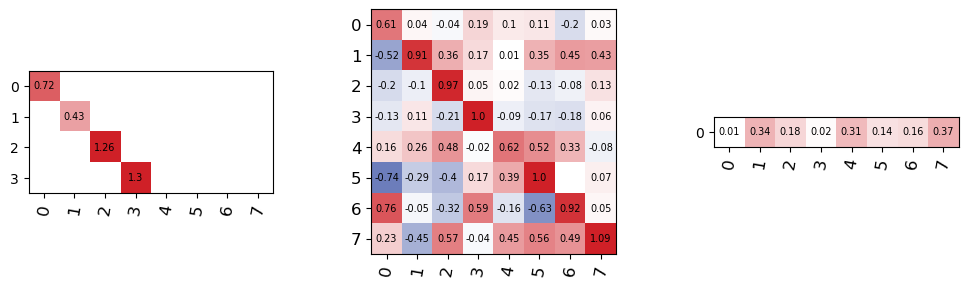

In [82]:
clusters = np.arange(LCn)
fig, ax = plt.subplots(1, 3, figsize = (12, 6))

mat = W_inp_inferred.T
img = ax[0].imshow(mat, cmap=cmap, vmin = -1, vmax = 1)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z) > 0.005:
        ax[0].text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
ax[0].set_xticks(np.arange(mat.shape[1]))
ax[0].set_yticks(np.arange(mat.shape[0]))
ax[0].set_xticklabels(clusters, rotation=80, fontsize=12)
# ax[0].set_yticklabels(clusters, rotation=0, fontsize=12)

mat = W_rec_inferred
img = ax[1].imshow(mat, cmap=cmap, vmin = -1, vmax = 1)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z) > 0.005:
        ax[1].text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
ax[1].set_xticks(np.arange(mat.shape[1]))
ax[1].set_yticks(np.arange(mat.shape[0]))
ax[1].set_xticklabels(clusters, rotation=80, fontsize=12)
ax[1].set_yticklabels(clusters, rotation=0, fontsize=12)

mat = W_out_inferred
img = ax[2].imshow(mat, cmap=cmap, vmin = -1, vmax = 1)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z) > 0.005:
        ax[2].text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
ax[2].set_xticks(np.arange(mat.shape[1]))
ax[2].set_yticks(np.arange(mat.shape[0]))
ax[2].set_xticklabels(clusters, rotation=80, fontsize=12)
# ax[2].set_yticklabels(clusters, rotation=0, fontsize=12)
plt.subplots_adjust(wspace=0.4)
plt.show()


In [83]:
activation_fun_circuit = lambda x: np.tanh(x)
N_LC = W_rec_inferred.shape[0]
circuit = RNN_numpy(N=N_LC, W_rec=W_rec_inferred, W_inp=W_inp_inferred, W_out=W_out_inferred, dt=dt, tau=tau, activation=activation_fun_circuit)
circuit.y = np.zeros(N_LC)

# defining RNN
N_RNN = rnn_data["N"]
x = np.random.randn(N_RNN)
W_rec = RNN_params["W_rec"]
W_inp = RNN_params["W_inp"]
W_out = RNN_params["W_out"]
dt = net_params["dt"]
tau = net_params["tau"]
activation_fun_RNN_np = lambda x: np.tanh(x)
RNN = RNN_numpy(N=N_RNN, W_rec=W_rec, W_inp=W_inp, W_out=W_out, dt=dt, tau=tau, activation=activation_fun_RNN_np)
RNN.y = np.zeros(N_RNN)

analyzer = LCAnalyzer(circuit, labels=clusters)
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
mask = np.array(rnn_config["mask"])

#MSE mse_score_RNN
score_function = lambda x, y: np.mean((x - y) ** 2)
mse_score = analyzer.get_validation_score(scoring_function=mse_scoring,
                                          input_batch=input_batch_valid,
                                          target_batch=target_batch_valid,
                                          mask=mask,
                                          sigma_rec=0,
                                          sigma_inp=0)
mse_score = np.round(mse_score, 8)
print(f"MSE: {mse_score}")

# Total variance
batch_size = input_batch_valid.shape[2]
RNN.clear_history()
circuit.clear_history()
RNN.run(input_timeseries=input_batch_valid, sigma_rec=0, sigma_inp=0)
RNN_trajectories = RNN.get_history()
RNN_output =RNN.get_output()
circuit.run(input_timeseries=input_batch_valid, sigma_rec=0, sigma_inp=0)
lc_trajectories = circuit.get_history()
lc_output = circuit.get_output()

lc_trajectories_emb = np.einsum("ji, ikp->jkp", Q, lc_trajectories)
RNN_trajectories_proj = np.einsum("ij, ikp->jkp", Q, RNN_trajectories)
r2_tot = np.mean([R2(lc_trajectories_emb[:, mask, i], RNN_trajectories[:, mask, i]) for i in range(batch_size)])
r2_proj = np.mean([R2(lc_trajectories[:, mask, i], RNN_trajectories_proj[:, mask, i]) for i in range(batch_size)])
print(f"Total R2: {r2_tot}")
print(f"Projected R2: {r2_proj}")
scores = {"mse_score": mse_score, "r2_tot":r2_tot, "r2_proj" : r2_proj}

MSE: 0.01349715
Total R2: 0.8317521459920055
Projected R2: 0.8828891208753937


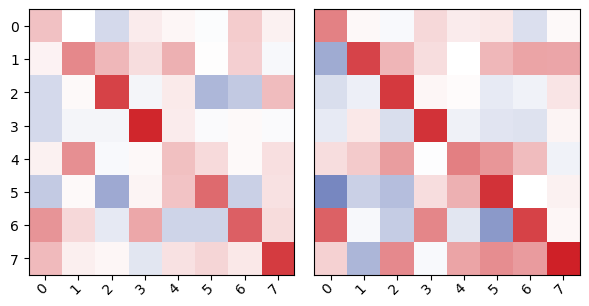

In [84]:
w_rec_bar = Q.T @ np.array(rnn_data["W_rec"]) @ Q
fig_w_rec_comparison = analyzer.plot_recurrent_matrix_comparison(w_rec_bar=w_rec_bar)
plt.show()

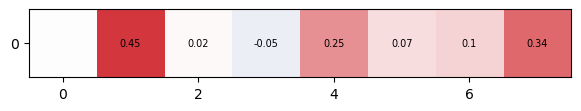

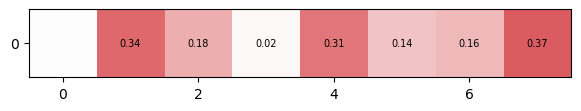

In [85]:
plot_matrix(W_out @ Q, vmin = -0.5, vmax = 0.5, show_numbers=True)
plot_matrix(W_out_inferred, vmin = -0.5, vmax = 0.5, show_numbers=True)

Plotting random trials


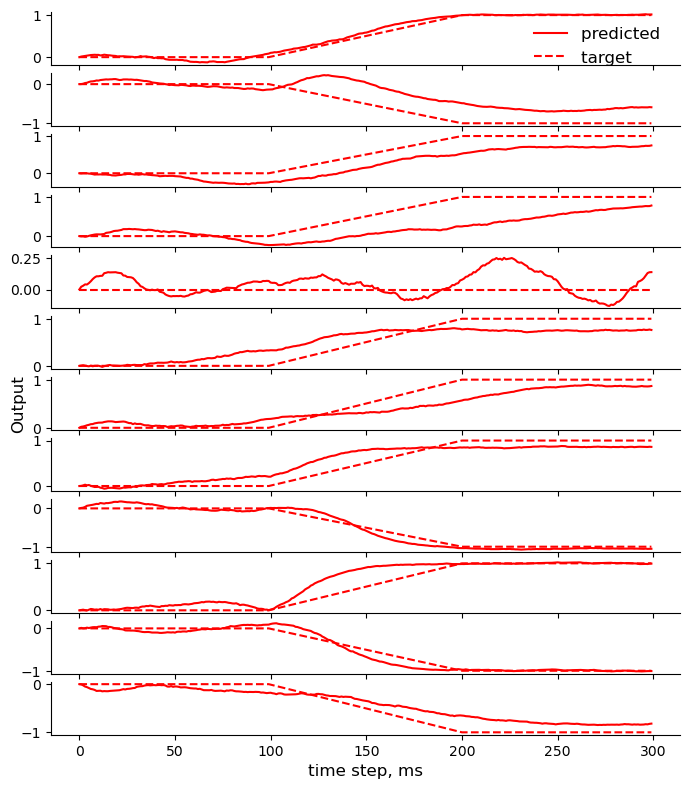

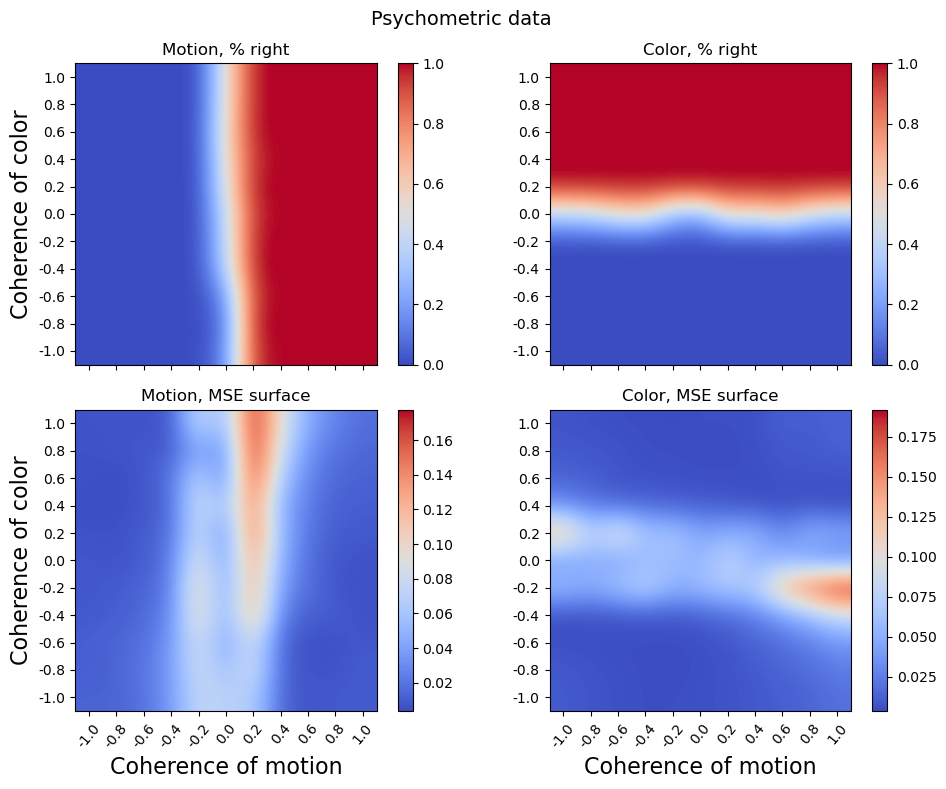

In [86]:
print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 12)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]
fig_trials = analyzer.plot_trials(inputs, targets, mask, sigma_rec=sigma_rec, sigma_inp=sigma_inp)
plt.show()

num_levels = len(task_data["coherences"])
analyzer.calc_psychometric_data(task, mask, num_levels=num_levels, num_repeats=31, sigma_rec=0.03, sigma_inp=0.03)
fig_psycho = analyzer.plot_psychometric_data()
plt.show()

Analyzing fixed points
Calculating Line Attractor analytics
Analyzing points on a line attractor in motion context...


  0%|          | 0/101 [00:00<?, ?it/s]

Analyzing points on a line attractor in color context...


  0%|          | 0/101 [00:00<?, ?it/s]

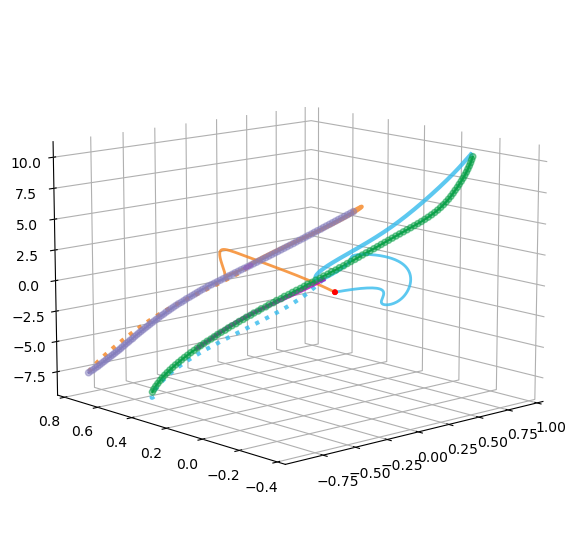

In [87]:
print(f"Analyzing fixed points")
dsa = DynamicSystemAnalyzerCDDM_tanh(circuit)
params = {"fun_tol": 0.0005,
          "diff_cutoff": 1e-4,
          "sigma_init_guess": 15,
          "patience": 50,
          "stop_length": 50,
          "mode": "exact"}
dsa.get_fixed_points(Input=np.array([1, 0, 0.0, 0.0]), **params)
dsa.get_fixed_points(Input=np.array([0, 1, 0.0, 0.0]), **params)
print(f"Calculating Line Attractor analytics")
dsa.calc_LineAttractor_analytics(N_points=101)
fig_LA3D = dsa.plot_LineAttractor_3D()
plt.show()